# The Battle of Students

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
 * [Map of Starting Situation](#methodology-start)
 * [Merge Data](#methodology-data)
 * [Foursquare](#methodology-foursquare)
 * [Exploratory Data Analysis](#methodology-analysis)
* [Results](#results)
* [Discussion and Conclusions](#conclusions)

**Note:** The final report of this project can be found [here](https://github.com/bneumayer/Coursera_Capstone/blob/master/tex/Assignment_The_Battle_of_Students_Final.pdf).

## 1. Introduction <a name="introduction"></a>

### Background

The city of Graz is the second biggest city in Austria with almost
330,000 residents.
It is a typical student city with roughly 60,000 students who mainly
live in the city.
The housing of students therefore is a significant economic
factor in Graz.
Accordingly, apartment-hunting is omnipresent and a time-consuming
issue.

Additionally, many companies in and around Graz
are offering employment to graduates of the different universities and
therefore, many move to Graz permanently after having finished their 
studies.
Since interest rates are currently at a low, people planning to study 
and having an intention to stay afterwards may consider to invest into 
the future, take out a loan and buy property.

### Problem

When considering to rent an apartment or to buy property, preferences
will differ significantly.
An apartment can be chosen considering the current situation in a 
certain borough or neighbourhood but for the acquisition of property the
outlook is more important.
Questions to be answered are:
* Where can I find affordable property?
* What is the current state of the borough?
* Will the value increase, stay or decrease over the years?

This requires a comprehensive analysis of rents, prices, the structure
of the different boroughs and the envrionmental circumstances.

### Target Audience

This data analysis project aims at upcoming students planning to move to
Graz with little or no knowledge on the structural and environmental
circumstances of the different boroughs.
The outcome is a classification of all available boroughs into groups
with similar characteristics regarding rents, property prices and
demographics.
Ultimately, the analysis provides conclusions on recommended boroughs
for renting an apartment or buying property.

## 2. Data <a name="data"></a>

* Information on the different boroughs of Graz including
	environmental and demographic characteristics can be obtaind
	from Wikipedia.
* The website www.immobilienscout24.at provides rent and
	property price information for Graz down to 
	borough-level.
	This information is based on advertisements posted on 
	and purchases made through this site.
* The website www.immowert123.at is owned by a real estate 
	agency evaluating and selling realty.
	The agency provides estimates for selected objects in Graz,
	including object type, size and recommended price.
* The Foursquare database is used to evaluate the
	vibrancy of a borough, which is based on the availability of venues 
	in a certain area.

The location data, i.e. latitude and longitude, for Graz and its boroughs
is acquired using \textit{geopy} with \textit{Nominatim} and\textit{ArcGIS}.

### 2.1 Get General Borough Information of Graz

In [1]:
import pandas as pd
from textwrap import wrap

# Wiki entry with boroughs of Graz
urlWiki = 'https://de.wikipedia.org/wiki/Liste_der_Stadtbezirke_von_Graz'

# Read in data: take care of different number enconding
GrazTable = pd.read_html(urlWiki, decimal=',', thousands='.')[1]

# Skip last row (sum) and keep postal code, name, area and population density
GrazTable = GrazTable.iloc[:-1, [7, 1, 4, 5]]
# Name columns
GrazTable.columns = list(['Postal Code', 'Borough', 'Area', 'Population Density'])
# Separate postacl codes
GrazTable['Postal Code'] = GrazTable['Postal Code'].apply(lambda r: wrap(r, 4)).str.join(', ')

In [2]:
# Show data
GrazTable.head(3)

,Postal Code,Borough,Area,Population Density
0,8010,Innere Stadt,1.16,3287
1,"8010, 8016",St. Leonhard,1.83,8650
2,"8010, 8013, 8015, 8036",Geidorf,5.50,4452


### 2.2 Get Borough Locations

In [3]:
import numpy as np

from geopy.geocoders import ArcGIS
geolocator = ArcGIS(user_agent="graz_explorer")

# Arrays for latitude and longitude
arrLat = np.zeros(GrazTable.shape[0])
arrLon = np.zeros(GrazTable.shape[0])


In [4]:
# Loop over all rows and retrieve latitude and longitude for each postal code
for idx, row in GrazTable.iterrows():
    print(idx, end=" ")
    address = '{}, Graz, Austria'.format(row.Borough)
    # Show borough
    print(row.Borough, end= "")
    # Add a tab when necessary
    if len(row.Borough)<6: print('\t', end="")
    
    # Get location
    location = geolocator.geocode(address)
    
    # Check if we got a valid result
    if (location != None):
        # Add location to output
        print('\tlat: {:.3f}, long: {:.3f}'.format(location.latitude, location.longitude))
        # Store result
        arrLat[idx] = location.latitude
        arrLon[idx] = location.longitude        
    else:
        print(', None')

0 Innere Stadt	lat: 47.072, long: 15.441
1 St. Leonhard	lat: 47.069, long: 15.456
2 Geidorf	lat: 47.085, long: 15.444
3 Lend		lat: 47.079, long: 15.419
4 Gries		lat: 47.057, long: 15.427
5 Jakomini	lat: 47.057, long: 15.451
6 Liebenau	lat: 47.032, long: 15.464
7 St. Peter	lat: 47.052, long: 15.478
8 Waltendorf	lat: 47.073, long: 15.482
9 Ries		lat: 47.081, long: 15.488
10 Mariatrost	lat: 47.107, long: 15.490
11 Andritz	lat: 47.113, long: 15.421
12 Gösting	lat: 47.107, long: 15.394
13 Eggenberg	lat: 47.071, long: 15.399
14 Wetzelsdorf	lat: 47.052, long: 15.401
15 Straßgang	lat: 47.031, long: 15.403
16 Puntigam	lat: 47.029, long: 15.435


In [5]:
# Add locations to table
GrazTable['Latitude'] = arrLat
GrazTable['Longitude'] = arrLon

# Rename inner city for better understanding
GrazTable['Borough'] = GrazTable['Borough'].str.replace('Innere Stadt', 'Inner City')

GrazTable.head(3)

,Postal Code,Borough,Area,Population Density,Latitude,Longitude
0,8010,Inner City,1.16,3287,47.07249,15.44114
1,"8010, 8016",St. Leonhard,1.83,8650,47.06945,15.45639
2,"8010, 8013, 8015, 8036",Geidorf,5.50,4452,47.08481,15.44361


### 2.3 Rent and Realty Prices

#### 2.3.1 First Data Source: Scout

In [6]:
# Rent and realty prices provided by a realty portal
urlHomeGraz = 'https://www.immobilienscout24.at/immobilienpreise/graz.html'

# Rent
TableGrazRent = pd.read_html(urlHomeGraz, decimal=',', thousands='.')[0]
TableGrazRent.columns=list(['Borough', 'Rent per sqm'])

# Realty prices
TableGrazRealty = pd.read_html(urlHomeGraz, decimal=',', thousands='.')[1]
TableGrazRealty.columns=list(['Borough', 'Price per sqm (Scout)'])

# Merge data
TableGrazHomeScout = TableGrazRent.merge(TableGrazRealty, on='Borough')
# Set missing values to NaN
TableGrazHomeScout.loc[TableGrazHomeScout['Price per sqm (Scout)']=='k.A.', 'Price per sqm (Scout)']=np.nan
# Convert data to float
TableGrazHomeScout['Price per sqm (Scout)'] = TableGrazHomeScout['Price per sqm (Scout)'].astype('float')
# Rename inner city for better understanding
TableGrazHomeScout['Borough'] = TableGrazHomeScout['Borough'].str.replace('Innere Stadt', 'Inner City')

TableGrazHomeScout.head(3)

,Borough,Rent per sqm,Price per sqm (Scout)
0,Inner City,12.90,3888.0
1,St. Leonhard,11.32,NaN
2,Geidorf,10.56,3811.0


#### 2.3.2 Second Data Source: Immo

In [7]:
# Base URL for all boroughs
baseUrl = 'https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/'

# Available data
urlSuffix = list(['innere-stadt', 'st-leonhard', 'geidorf', 'lend', 'gries', 'jakomini',
                  'liebenau',   #liebenau
                  'engelsdorf', #liebenau
                  'st-peter', 'waltendorf',
                  'ragnitz',    # ries
                  'wenisbuch',  # mariatrost
                  'andritz', 'goesting',
                  'algersdorf', #eggenberg
                  'baierdorf',  #eggenberg
                  'wetzelsdorf', 'straszgang',
                  'rudersdorf'  #puntigam
                 ])

urlSuffixNames = list(['Inner City', 'St. Leonhard', 'Geidorf', 'Lend', 'Gries', 'Jakomini', 'Liebenau', 
                       'Engelsdorf', 'St. Peter', 'Waltendorf', 'Ragnitz', 'Wenisbuch', 'Andritz', 'Gösting', 
                       'Algersdorf', 'Baierdorf', 'Wetzelsdorf', 'Straßgang', 'Rudersdorf'
                      ])

In [8]:
import requests
from bs4 import BeautifulSoup

# Make a test output for one entry
#
testEntryNum = 8;
# Use beautiful soup to parse website
testUrl = baseUrl + urlSuffix[testEntryNum]
rawData = requests.get(testUrl)
data = rawData.text
soup = BeautifulSoup(data, 'html.parser')
#
# Read in the second table and extract all rows
table = soup.findAll('div', {'class': 'col-12'})[1]
rows = table.findAll('div', {'class': 'row'})
# Create a dataframe
df = pd.DataFrame([row.text.strip().split('\n') for row in rows], columns = list(['Type', 'Postal Code', 'Size', 'Price']))
# Drop first row with German column names
df.drop(index=0, axis=0, inplace=True)
# Search for all occurences of the German word for flat (Wohnung)
df = df[df['Type'].str.contains('Wohnung|wohnung', regex=True)].reset_index(drop=True)

# Rename for better understanding
df['Type'] = df['Type'].str.replace('Wohnung', 'Apartment')
df['Type'] = df['Type'].str.replace('Vorsorgewohnung', 'Investment Apartment')
df['Type'] = df['Type'].str.replace('Souterrainwohnung', 'Souterrain')
df['Type'] = df['Type'].str.replace('Galeriewohnung', 'Gallery Apartment')
df['Type'] = df['Type'].str.replace('Architektenwohnung', 'Architect Apartment')
df['Type'] = df['Type'].str.replace('Terrassenwohnung', 'Terrace Apartment')
df['Type'] = df['Type'].str.replace('Dachgeschoßwohnung', 'Penthouse')
df['Type'] = df['Type'].str.replace('Gartenwohnung', 'Garden Apartment')

# Get rid of special characters and convert prices to float, take care of number encoding
df['Size'] = df['Size'].str.replace(',','.').str.slice(stop=-2).astype('float')
df['Price'] = df['Price'].str.replace('.','').str.slice(start=2, stop=-1).astype('float')
# Calculate average flat price
df['Price per sqm (Immo)'] = (df['Price']/df['Size'])

# Show the results of this test entry
print(testUrl)
print('{}: Average Price per square metre: EUR {:.2f}'.format(
    urlSuffixNames[testEntryNum], df['Price per sqm (Immo)'].mean()))
df

https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/st-peter
St. Peter: Average Price per square metre: EUR 2906.95


,Type,Postal Code,Size,Price,Price per sqm (Immo)
0,Apartment,8042,45.10,120900.0,2680.709534
1,Garden Apartment,8042,55.00,174800.0,3178.181818
2,Investment Apartment,8042,44.83,125400.0,2797.233995
3,Penthouse,8042,113.00,335800.0,2971.681416


In [9]:
# Perform the analysis shown above for all available URLs
avgPriceArray = np.zeros(len(urlSuffix))

# Loop over all entries
for idx, url in enumerate(urlSuffix):
    # Use beautiful soup to parse website
    rawData = requests.get(baseUrl + url)
    data = rawData.text
    soup = BeautifulSoup(data, 'html.parser')
    # Read in the second table and extract all rows
    table = soup.findAll('div', {'class': 'col-12'})[1]
    rows = table.findAll('div', {'class': 'row'})
    # Create a dataframe
    df = pd.DataFrame([row.text.strip().split('\n') for row in rows], columns = 
                      list(['Type', 'Postal Code', 'Size', 'Price']))
    # Drop first row with German column names
    df.drop(index=0, axis=0, inplace=True)
    # Search for all occurences of the German word for flat (Wohnung)
    df = df[df['Type'].str.contains('Wohnung|wohnung',regex=True)].reset_index(drop=True)
    # Get rid of special characters and convert prices to float, take care of number encoding
    df['Size'] = df['Size'].str.replace(',','.').str.slice(stop=-2).astype('float')
    df['Price'] = df['Price'].str.replace('.','').str.slice(start=2, stop=-1).astype('float')
    df['Price per sqm'] = (df['Price']/df['Size'])
    # Calculate average flat price
    avgPrice = df['Price per sqm'].mean()
    
    # Show results
    #
    if len(url)<5:
        print('{}\t\t{:.2f}'.format(baseUrl+url, avgPrice))
    else:
        print('{}\t{:.2f}'.format(baseUrl+url, avgPrice))
    
    # Store the average flat price
    avgPriceArray[idx] = avgPrice


https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/innere-stadt	5397.78
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/st-leonhard	2221.93
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/geidorf	2078.25
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/lend		1855.58
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/gries	2234.76
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/jakomini	2049.54
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/liebenau	1854.78
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/engelsdorf	2231.33
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/st-peter	2906.95
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/waltendorf	1819.11
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/ragnitz	2303.90
https://www.immowert123.at/grundstueckspreise/steiermark/grazstadt/wenisb

In [10]:
TableGrazHomeImmo = pd.DataFrame({'Borough': urlSuffixNames,
                                  'Price per sqm (Immo)': avgPriceArray})
TableGrazHomeImmo.head(3)

,Borough,Price per sqm (Immo)
0,Inner City,5397.783378
1,St. Leonhard,2221.927651
2,Geidorf,2078.248241


## 3 Methodology <a name="methodology"></a>

In this chapter the data is visualised, further prepared, merged and finally clustered.

### 3.1 Folium Map Describing the Situation <a name="methodology-start"></a>

In [11]:
import folium

# Location of Graz
locGraz = geolocator.geocode('Graz, Austria')

from geopy.geocoders import Nominatim
geolocatorAdd = Nominatim(user_agent="graz_region_explorer")

# The second data source did not provide data for all boroughs but for additional regions.
# Let's see where the additional regions are.
#
# Available data
addRegions = list(['Engelsdorf', #liebenau
                   'Ragnitz',    #ries
                   'Wenisbuch',  #mariatrost
                   'Algersdorf', #eggenberg
                   'Baierdorf',  #eggenberg
                   'Rudersdorf'  #puntigam
                 ])

arrAddLat = np.zeros(len(addRegions))
arrAddLon = np.zeros(len(addRegions))

# Loop over all regions and retrieve latitude and longitude for each postal code
for idx, region in enumerate(addRegions):
    print(idx, end=" ")
    # Use different geolocator for additional regions
    address = '{}, Graz, Austria'.format(region)
    # Show region
    print(region, end= "")
    # Add a tab when necessary
    #if len(region)<6: print('\t', end="")
    
    # Get location
    location = geolocatorAdd.geocode(address)
    
    # Check if we got a valid result
    if (location != None):
        # Add location to output
        print('\tlat: {:.3f}, long: {:.3f}'.format(location.latitude, location.longitude))
        # Store result
        arrAddLat[idx] = location.latitude
        arrAddLon[idx] = location.longitude        
    else:
        print(', None')
    

0 Engelsdorf	lat: 47.030, long: 15.465
1 Ragnitz	lat: 47.075, long: 15.511
2 Wenisbuch	lat: 47.118, long: 15.477
3 Algersdorf	lat: 47.077, long: 15.391
4 Baierdorf	lat: 47.068, long: 15.392
5 Rudersdorf	lat: 47.021, long: 15.443


In [12]:
mapGraz = folium.Map(location=[locGraz.latitude, locGraz.longitude], zoom_start=12)

# Radius used for foursquare
RADIUS = 350

for name, lat, lon, area in zip(GrazTable['Borough'], GrazTable['Latitude'], GrazTable['Longitude'], GrazTable['Area']):
    label = folium.Popup(name, parse_html=True)
    
    # Show a circle for the area investigated using foursquare
    folium.Circle(
    [lat, lon],
    radius = np.max([RADIUS * np.sqrt(area), 500]),
    color = None,
    fill=True,
    fill_opacity=0.7,
    fill_color = 'grey'
    ).add_to(mapGraz)
    
    # Mark the center of a borough
    folium.CircleMarker(
        [lat, lon],
        popup = label,
        radius = 5,
        fill=True,
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(mapGraz)

# Add additional regions to see how they fit to the shown boroughs
for name, lat, lon in zip(addRegions, arrAddLat, arrAddLon):
    label = folium.Popup(name, parse_html=True)
    
    # Show a marker for additional region
    folium.Marker(
        [lat,lon],
        popup=label,        
        icon=folium.Icon(color='cadetblue')
    ).add_to(mapGraz)

# Show the map
mapGraz

### 3.2 Merge Rent and Price Data <a name="methodology-data"></a>

#### 3.2.1 Reorder Results from Second Data Source

In [13]:
# New dataframe
TableGrazHomeImmo_reord = TableGrazHomeImmo

# From our map we know that we can combine the data from:
#
# Liebenau and Engelsdorf
TableGrazHomeImmo_reord.loc[TableGrazHomeImmo_reord['Borough']=='Liebenau', 'Price per sqm (Immo)'] = \
TableGrazHomeImmo_reord.loc[TableGrazHomeImmo_reord['Borough'].str.contains('Engelsdorf|Liebenau'), \
                            'Price per sqm (Immo)'].mean()
TableGrazHomeImmo_reord = TableGrazHomeImmo_reord[TableGrazHomeImmo_reord['Borough']!='Engelsdorf'].reset_index(drop=True)
# Baierndorf and Algersdorf
TableGrazHomeImmo_reord.loc[TableGrazHomeImmo_reord['Borough']=='Baierdorf', 'Price per sqm (Immo)'] = \
TableGrazHomeImmo_reord.loc[TableGrazHomeImmo_reord['Borough'].str.contains('Baierdorf|Algersdorf'), \
                            'Price per sqm (Immo)'].mean()
TableGrazHomeImmo_reord.loc[TableGrazHomeImmo_reord['Borough']=='Baierdorf', 'Borough'] = 'Eggenberg'
TableGrazHomeImmo_reord = TableGrazHomeImmo_reord[TableGrazHomeImmo_reord['Borough']!='Algersdorf'].reset_index(drop=True)

# Further, we can rename
#
# Rudersdorf to Puntigam
TableGrazHomeImmo_reord.loc[TableGrazHomeImmo_reord['Borough']=='Rudersdorf', 'Borough'] = 'Puntigam'
# Ragnitz to Ries
TableGrazHomeImmo_reord.loc[TableGrazHomeImmo_reord['Borough']=='Ragnitz', 'Borough'] = 'Ries'
# Wenisbuch to Mariatrost
TableGrazHomeImmo_reord.loc[TableGrazHomeImmo_reord['Borough']=='Wenisbuch', 'Borough'] = 'Mariatrost'

#### 3.2.2 Merge Results

In [14]:
TableGrazHome_merged = TableGrazHomeScout.merge(TableGrazHomeImmo_reord, on='Borough')
TableGrazHome_merged['Average Price per sqm'] = np.mean(TableGrazHome_merged.loc[:, ['Price per sqm (Scout)', \
                                                                                     'Price per sqm (Immo)']], axis=1)

print('{} entries in merged dataset'.format(TableGrazHome_merged.shape[0]))
TableGrazHome_merged.head(3)

17 entries in merged dataset


,Borough,Rent per sqm,Price per sqm (Scout),Price per sqm (Immo),Average Price per sqm
0,Inner City,12.90,3888.0,5397.783378,4642.891689
1,St. Leonhard,11.32,NaN,2221.927651,2221.927651
2,Geidorf,10.56,3811.0,2078.248241,2944.624120


### 3.3 Foursquare <a name="methodology-foursquare"></a>

In [15]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

CLIENT_ID = '' # removed for upload
CLIENT_SECRET = '' # removed for upload
VERSION = '20180605' # Foursquare API version

In [16]:
# Define a venue limit
LIMIT = 100

In [17]:
def getNearbyVenues(names, latitudes, longitudes, area, radius=500):
    
    venues_list=[]
    for name, lat, lng, area in zip(names, latitudes, longitudes, area):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            np.max([radius * np.sqrt(area), 500]), 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
GrazVenues = getNearbyVenues(names=GrazTable['Borough'],
                             latitudes=GrazTable['Latitude'],
                             longitudes=GrazTable['Longitude'],
                             area=GrazTable['Area'],
                             radius=RADIUS
                                  )

Inner City
St. Leonhard
Geidorf
Lend
Gries
Jakomini
Liebenau
St. Peter
Waltendorf
Ries
Mariatrost
Andritz
Gösting
Eggenberg
Wetzelsdorf
Straßgang
Puntigam


In [19]:
print('Data set size: {}'.format(GrazVenues.shape))
GrazVenues.head(3)

Data set size: (348, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Inner City,47.07249,15.44114,Eis-Greissler,47.072120,15.438734,Ice Cream Shop
1,Inner City,47.07249,15.44114,Delikatessen Frankowitsch,47.070623,15.441221,Gourmet Shop
2,Inner City,47.07249,15.44114,Café Mitte,47.072975,15.440947,Bar


### 3.4 Exploratory Data Analysis <a name="methodology-analysis"></a>

We need to check if our variables are independent. Of special importance will be if vibrance correlates with rent or price. In that case there would not be much left to analyse.

#### 3.4.1 Rent and Realty Prices

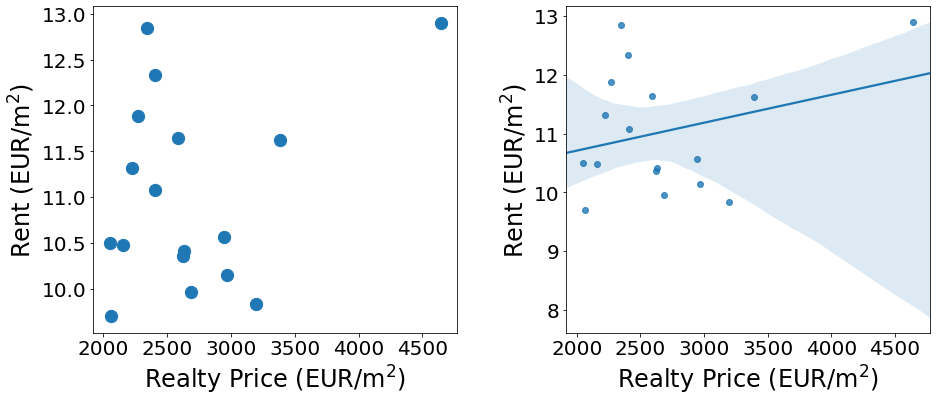

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size=20)
plt.figure(figsize=(15,6))
# Have a quick look at the correlation between rent and price
plt.subplot(1,2,1)
plt.scatter(x=TableGrazHome_merged['Average Price per sqm'], y=TableGrazHome_merged['Rent per sqm'], s=150)
plt.xlabel(r'Realty Price (EUR/m$^2$)', fontsize=24)
plt.ylabel(r'Rent (EUR/m$^2$)', fontsize=24)
# 
plt.subplot(1,2,2)
sns.regplot(x=TableGrazHome_merged['Average Price per sqm'], y=TableGrazHome_merged['Rent per sqm'])
plt.xlabel(r'Realty Price (EUR/m$^2$)', fontsize=24)
plt.ylabel(r'Rent (EUR/m$^2$)', fontsize=24)

plt.subplots_adjust(wspace=0.3)
plt.show()

#### 3.4.2 Rent, Prices and Vibrancy of Boroughs

In [23]:
# Group venues by Borough
GrazVenues_grouped = GrazVenues.groupby('Borough')[['Venue']].count()
# Sort in ascending order
GrazVenues_grouped_srt = GrazVenues_grouped.sort_values(by='Venue', ascending=True)

# Sort prices by same order 
TableGrazHome_merged_srt = TableGrazHome_merged.copy()
TableGrazHome_merged_srt.set_index('Borough', inplace=True)
TableGrazHome_merged_srt = TableGrazHome_merged_srt.loc[GrazVenues_grouped_srt.index, :]

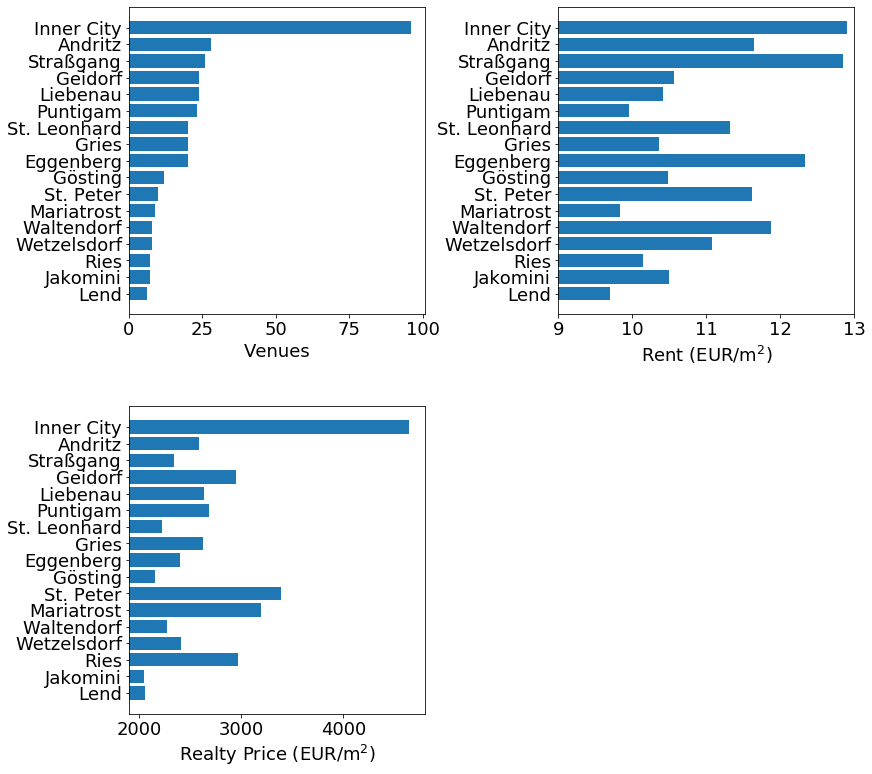

In [24]:
# Compare venues, rent and realty price
plt.rc('font', size=18)
plt.figure(figsize=[13,13])
#
plt.subplot(2,2,1)
plt.barh(np.arange(GrazTable.shape[0]), GrazVenues_grouped_srt['Venue'])
plt.yticks(np.arange(GrazTable.shape[0]), GrazVenues_grouped_srt.index)
plt.xlabel('Venues');
#
plt.subplot(2,2,2)
plt.barh(np.arange(GrazTable.shape[0]), TableGrazHome_merged_srt['Rent per sqm'])
plt.yticks(np.arange(GrazTable.shape[0]), TableGrazHome_merged_srt.index)
plt.xlim((9, 13))
plt.xlabel(r'Rent (EUR/m$^2$)');
#
plt.subplot(2,2,3)
plt.barh(np.arange(GrazTable.shape[0]), TableGrazHome_merged_srt['Average Price per sqm'])
plt.yticks(np.arange(GrazTable.shape[0]), TableGrazHome_merged_srt.index)
plt.xlim((1900, 4800))
plt.xlabel(r'Realty Price (EUR/m$^2$)');

plt.subplots_adjust(wspace=0.45, hspace=0.3)
plt.show()

#### 3.4.3 Population Density and Vibrancy

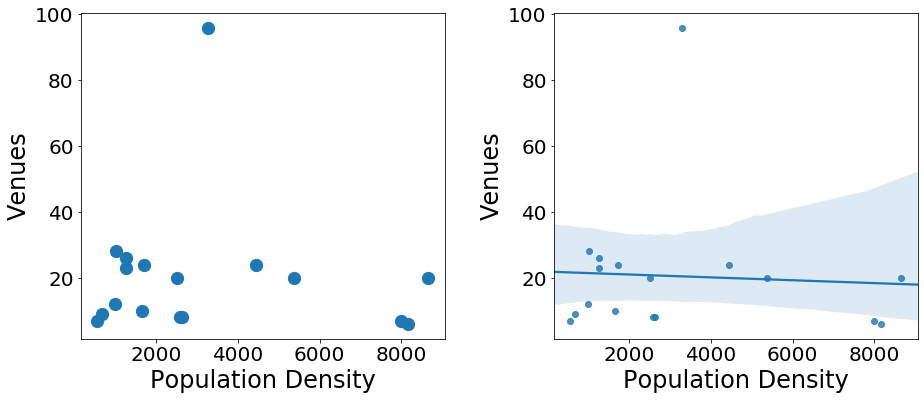

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

df_tmp = GrazTable.merge(GrazVenues_grouped, on='Borough')[['Population Density', 'Venue']]

plt.rc('font', size=20) 
plt.figure(figsize=(15,6))
# Have a quick look at the correlation between rent and price
plt.subplot(1,2,1)
plt.scatter(x=df_tmp['Population Density'], y=df_tmp['Venue'], s=150)
plt.xlabel('Population Density', fontsize=24)
plt.ylabel('Venues', fontsize=24)
# 
plt.subplot(1,2,2)
sns.regplot(x=df_tmp['Population Density'], y=df_tmp['Venue'])
plt.xlabel('Population Density', fontsize=24)
plt.ylabel('Venues', fontsize=24)

plt.subplots_adjust(wspace=0.3)
plt.show()

### 3.5 Data Clustering <a name="methodology-clustering"></a>

#### 3.5.1 Prepare Data

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Put entire information together
TableGrazHome_cluster = TableGrazHome_merged.merge(GrazTable, on='Borough')
TableGrazHome_cluster = TableGrazHome_cluster.merge(GrazVenues_grouped_srt, on='Borough')
TableGrazHome_cluster = TableGrazHome_cluster.drop(
    columns={'Price per sqm (Scout)', 'Price per sqm (Immo)', 'Postal Code', 'Latitude', 'Longitude'}).set_index('Borough')
TableGrazHome_cluster.head(3)

,Rent per sqm,Average Price per sqm,Area,Population Density,Venue
Borough,,,,,
Inner City,12.90,4642.891689,1.16,3287,96
St. Leonhard,11.32,2221.927651,1.83,8650,20
Geidorf,10.56,2944.624120,5.50,4452,24


In [27]:
# We'll define two data sets

# Rent:
#
# We will use
df_rent = TableGrazHome_cluster.drop(columns={'Average Price per sqm'})

# Realty
df_realty = TableGrazHome_cluster.drop(columns={'Rent per sqm'})

In [28]:
# Normalize our data
rent_cluster = StandardScaler().fit_transform(df_rent)
realty_cluster = StandardScaler().fit_transform(df_realty)

In [29]:
# K-means clustering
numClust = 5
kMeansGraz = KMeans(n_clusters=numClust, init='k-means++', n_init=12, max_iter=300)

In [30]:
# Rent
kMeansGraz_rent = kMeansGraz.fit(rent_cluster)

# Realty
kMeansGraz_realty = kMeansGraz.fit(realty_cluster)

#### 3.5.2 Check the results

In [31]:
# Check if there is a difference between the clustering
if (np.sum(kMeansGraz_rent.labels_ - kMeansGraz_realty.labels_)):
    print('Different clusters for rent and realty data.')
else:
    print('Same clusters for rent and realty.')

Same clusters for rent and realty.


In [32]:
finalTable = TableGrazHome_merged.merge(GrazTable, on='Borough').drop(
    columns={'Price per sqm (Scout)', 'Price per sqm (Immo)', 'Postal Code'})
# Add venues labels to the table
finalTable = finalTable.merge(GrazVenues_grouped, on='Borough')
finalTable = finalTable.rename(columns={'Venue': 'Venue Count'})
# Add cluster labels to the table
finalTable['Cluster'] = kMeansGraz_realty.labels_

finalTable.head(3)

,Borough,Rent per sqm,Average Price per sqm,Area,Population Density,Latitude,Longitude,Venue Count,Cluster
0,Inner City,12.90,4642.891689,1.16,3287,47.07249,15.44114,96,1
1,St. Leonhard,11.32,2221.927651,1.83,8650,47.06945,15.45639,20,3
2,Geidorf,10.56,2944.624120,5.50,4452,47.08481,15.44361,24,0


## 4. Results <a name="results"></a>

Clustering provides 5 clusters with 7, 1, 3, 3 and 3 boroughs, respectively.

* The largest cluster provides moderate rent and a lively neighbourhood.
* The smallest cluster is the inner city and expensive.
* Cluster 2 consists of 3 boroughs, shows low rent, high realty prices and low vibrancy in the environment.
* Cluster 3 consists of 3 boroughs and is cheap but very densely populated.
* Cluster 4 consists of 3 boroughs, shows rather high rent, moderate realty prices and a rather vibrant neighbourhood.

**Note:** Cluster numbers may change when you re-run the cells.

### 4.1 Clusters

In [33]:
finalTable[finalTable['Cluster']==0]

,Borough,Rent per sqm,Average Price per sqm,Area,Population Density,Latitude,Longitude,Venue Count,Cluster
2,Geidorf,10.56,2944.624120,5.50,4452,47.08481,15.44361,24,0
4,Gries,10.36,2621.380675,5.05,5386,47.05672,15.42688,20,0
6,Liebenau,10.41,2632.527983,7.99,1723,47.03230,15.46449,24,0
8,Waltendorf,11.88,2270.054059,4.48,2648,47.07256,15.48158,8,0
13,Eggenberg,12.33,2402.925951,7.79,2509,47.07111,15.39883,20,0
14,Wetzelsdorf,11.08,2408.188601,5.77,2599,47.05190,15.40077,8,0
16,Puntigam,9.96,2683.333333,6.18,1272,47.02872,15.43471,23,0


In [34]:
finalTable[finalTable['Cluster']==1]

,Borough,Rent per sqm,Average Price per sqm,Area,Population Density,Latitude,Longitude,Venue Count,Cluster
0,Inner City,12.9,4642.891689,1.16,3287,47.07249,15.44114,96,1


In [35]:
finalTable[finalTable['Cluster']==2]

,Borough,Rent per sqm,Average Price per sqm,Area,Population Density,Latitude,Longitude,Venue Count,Cluster
11,Andritz,11.64,2588.170448,18.47,1023,47.11285,15.42132,28,2
12,Gösting,10.48,2156.959991,10.83,1003,47.10659,15.39359,12,2
15,Straßgang,12.85,2344.702614,11.75,1265,47.03078,15.40277,26,2


In [36]:
finalTable[finalTable['Cluster']==3]

,Borough,Rent per sqm,Average Price per sqm,Area,Population Density,Latitude,Longitude,Venue Count,Cluster
1,St. Leonhard,11.32,2221.927651,1.83,8650,47.06945,15.45639,20,3
3,Lend,9.70,2061.288869,3.70,8162,47.07944,15.41866,6,3
5,Jakomini,10.50,2049.535035,4.06,7979,47.05714,15.45063,7,3


In [37]:
finalTable[finalTable['Cluster']==4]

,Borough,Rent per sqm,Average Price per sqm,Area,Population Density,Latitude,Longitude,Venue Count,Cluster
7,St. Peter,11.62,3388.475845,8.86,1655,47.05155,15.47759,10,4
9,Ries,10.15,2967.948923,10.16,573,47.08078,15.48768,7,4
10,Mariatrost,9.83,3196.892857,13.99,678,47.10747,15.48955,9,4


### 4.2 Compare Averages of Clusters

In [38]:
df = finalTable[['Cluster','Rent per sqm', 'Average Price per sqm', 'Area', 'Population Density', 'Venue Count']]
dfAvg = df[df['Cluster']==0].groupby('Cluster').mean()
dfAvg = dfAvg.append(df[df['Cluster']==1].groupby('Cluster').mean())
dfAvg = dfAvg.append(df[df['Cluster']==2].groupby('Cluster').mean())
dfAvg = dfAvg.append(df[df['Cluster']==3].groupby('Cluster').mean())
dfAvg = dfAvg.append(df[df['Cluster']==4].groupby('Cluster').mean())
dfAvg

,Rent per sqm,Average Price per sqm,Area,Population Density,Venue Count
Cluster,,,,,
0,10.940000,2566.147817,6.108571,2941.285714,18.142857
1,12.900000,4642.891689,1.160000,3287.000000,96.000000
2,11.656667,2363.277684,13.683333,1097.000000,22.000000
3,10.506667,2110.917185,3.196667,8263.666667,11.000000
4,10.533333,3184.439208,11.003333,968.666667,8.666667


## 5 Discussion and Conclusions <a name="conclusions"></a>

### 5.1 Interpretation of the Clusters

The clusters are interpreted as follows:

* Buy here! Affordable prices, moderate entertainment (dark green).
* Rent here! Affordable rent, lively environment (light green).
* Cheap but densely populated (orange).
* Cheap rent but little entertainment (light red).
* Simply expensive (dark red).

In [39]:
finalTable['Recommendation'] = finalTable['Cluster']

# After checking our results, we can set our recommendations
for cluster in range(0,numClust):
    tmpAvg = finalTable[finalTable['Cluster']==cluster].groupby('Cluster').mean()
    #
    rent  = tmpAvg.loc[cluster,'Rent per sqm']
    venue = tmpAvg.loc[cluster,'Venue Count']
    price = tmpAvg.loc[cluster,'Average Price per sqm']
    popul = tmpAvg.loc[cluster,'Population Density']
            
    if rent<11 and venue>17:
        # Rent here!
        finalTable.loc[finalTable['Cluster']==cluster, 'Recommendation'] = 1
    elif price<2400 and venue>20:
        # Buy here!
        finalTable.loc[finalTable['Cluster']==cluster, 'Recommendation'] = 2
    elif popul > 8000:
        # Cheap but densely populated.
        finalTable.loc[finalTable['Cluster']==cluster, 'Recommendation'] = 3
    elif rent<10.6 and venue<9:
        # Cheap rent but little entertainment.
        finalTable.loc[finalTable['Cluster']==cluster, 'Recommendation'] = 4
    elif rent > 12:
        # Simply Expensive.
        finalTable.loc[finalTable['Cluster']==cluster, 'Recommendation'] = 5

### 5.2 Cluster Map

In [40]:
#import matplotlib.cm as cm
#import matplotlib.colors as colors
#colors_array = cm.rainbow(np.linspace(0, 1, len(set(finalTable['Cluster']))+2))
#rainbow = [colors.rgb2hex(i) for i in colors_array]


mapGrazCluster = folium.Map(location=[locGraz.latitude, locGraz.longitude], zoom_start=12)

for name, lat, lon, cluster, recomm in zip(finalTable['Borough'], finalTable['Latitude'], finalTable['Longitude'], finalTable['Cluster'], finalTable['Recommendation']):
    label = folium.Popup(name, parse_html=True)
    
    # Add info with cluster interpretation
    if recomm==1:
        info = 'Rent here! Affordable rent, lively environment.'
        infocolor = 'lightgreen'        
    elif recomm==2:
        info = 'Buy here! Affordable prices, moderate entertainment.'
        infocolor = 'darkgreen'
    elif recomm==3:
        info = 'Cheap but densely populated.'
        infocolor = 'orange'        
    elif recomm==4:
        info = 'Cheap rent but little entertainment.'
        infocolor = 'red'
    elif recomm==5:
        info = 'Simply expensive.'
        infocolor = 'darkred'
    
    # Mark the center of a borough
    folium.CircleMarker(
        [lat, lon],
        popup = label,
        radius = 10,
        color = infocolor,
        fill_color = infocolor,
        fill=True,
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(mapGrazCluster)
        
    folium.Marker(
        [lat, lon],
        popup = info,
        icon=folium.Icon(color = infocolor)
    ).add_to(mapGrazCluster)

# Show the map
mapGrazCluster

### 5.3 Discussion

The final results look reasonable for a typical student city: the cluster 
of boroughs recommended for renting is the largest one consisting of 
7~boroughs.
Furthermore, the inner city is not recommended for students, since it is
too expensive and boroughs including or being close to transport hubs
are cheap but densely populated.

Cluster 2 is more expensive, less populated and only shows little vibrancy -- characteristics of the periphery. 
For cluster 4, on the other hand, realty prices are lower and it provides more entertainment -- a developing borough promising an increase in value.
This shows that the choice of 5 clusters was necessary since a reduction to 4 clusters would group these two clusters.

### 5.4 Conclusions

This data analysis project showed that a recommendation system
for renting and buying apartments in Graz is generally feasible.
The results are derived from an objective analysis, i.e. a clustering
of similar characteristics, look reasonable and are based on freely 
available data.
It is furthermore noteworthy that this approach can simply be
applied to any other location provided the required information
is available.